# Code for model estimation

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

In [102]:
l = 2
set_id = 3
fold_n = 0
#                            models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_5 lrs_2oct_newC43NoDup_ClassSet8 _ManCorected_registered_350epochs_fold-0/validation4_logits_predictions.csv
validation_file_path="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation4_logits_predictions.csv".format(l, set_id, fold_n)
train_file_path="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train4_logits_predictions.csv".format(l, set_id, fold_n)

df_val = pd.read_csv(validation_file_path, index_col=0)
df_train = pd.read_csv(train_file_path, index_col=0)


In [103]:
df_val

,true_value,pred_value,logit_0,logit_1,logit_2,logit_3
0,0.0,0.0,10.862171,-3.860684,-3.940548,-2.183483
1,0.0,2.0,-10.078033,-12.643808,15.660099,7.538659
2,0.0,0.0,10.862171,-3.860684,-3.940548,-2.183483
3,0.0,1.0,-0.770609,3.256650,-2.877132,0.536556
4,0.0,0.0,8.381739,-1.337310,-4.462004,-2.587733
...,...,...,...,...,...,...
175,3.0,3.0,-7.954622,-1.330556,3.344617,5.879862
176,3.0,3.0,-4.412617,-7.270431,2.767723,9.146964
177,3.0,0.0,5.477484,0.297902,-4.540776,-1.008942
178,3.0,2.0,-7.815864,-3.889286,7.416153,4.059173


In [104]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(df_val['true_value'], df_val['pred_value'], average='weighted')

(0.7206156156156156, 0.7166666666666667, 0.7183608841980127, None)

In [105]:
import seaborn as sn

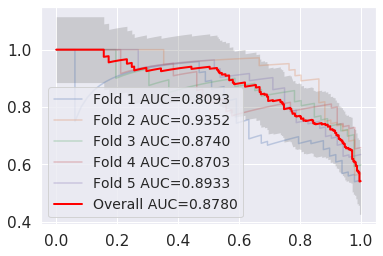

In [106]:
# https://stackoverflow.com/questions/55541254/precision-recall-curve-with-n-fold-cross-validation-showing-standard-deviation

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from numpy import interp
from sklearn.metrics import auc

X, y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=10.0,
    random_state=10)

k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
predictor = SVC(kernel='linear', C=1.0, probability=True, random_state=10)

y_real = []
y_proba = []

precision_array = []
threshold_array=[]
recall_array = np.linspace(0, 1, 100)

for i, (train_index, test_index) in enumerate(k_fold.split(X)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision_fold, recall_fold, thresh = precision_recall_curve(ytest, pred_proba[:,1])
    precision_fold, recall_fold, thresh = precision_fold[::-1], recall_fold[::-1], thresh[::-1]  # reverse order of results
    thresh = np.insert(thresh, 0, 1.0)
    precision_array = interp(recall_array, recall_fold, precision_fold)
    threshold_array = interp(recall_array, recall_fold, thresh)
    pr_auc = auc(recall_array, precision_array)

    lab_fold = 'Fold %d AUC=%.4f' % (i+1, pr_auc)
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))

plt.plot(recall, precision, lw=2,color='red', label=lab)

plt.legend(loc='lower left', fontsize='small')

mean_precision = np.mean(precision_array)
std_precision = np.std(precision_array)
plt.fill_between(recall, precision + std_precision, precision - std_precision, alpha=0.3, linewidth=0, color='grey')
plt.show()

# Metrics calculation

In [107]:
from sklearn.metrics import roc_auc_score

class MultiClassMetrics():
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        
    def calculate_scores(self, class_mapping_dict=None):
    
        y_true_ = self.y_true
        y_pred_ = self.y_pred
        if classes_map_dict is not None:
            y_true_ = y_true_.map(classes_map_dict)
            y_pred_ = y_pred_.map(classes_map_dict)
    
        self.cnf_matrix = confusion_matrix(y_true_, y_pred_)
        self.FP = self.cnf_matrix.sum(axis=0) - np.diag(self.cnf_matrix) 
        self.FN = self.cnf_matrix.sum(axis=1) - np.diag(self.cnf_matrix)
        self.TP = np.diag(self.cnf_matrix)
        self.TN = self.cnf_matrix.sum() - (self.FP + self.FN + self.TP)
        self.FP = self.FP.astype(float)
        self.FN = self.FN.astype(float)
        self.TP = self.TP.astype(float)
        self.TN = self.TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
        self.TPR = self.TP/(self.TP+self.FN)
        # Specificity or true negative rate
        self.TNR = self.TN/(self.TN+self.FP) 
        # Precision or positive predictive value
        self.PPV = self.TP/(self.TP+self.FP)
        # Negative predictive value
        self.NPV = self.TN/(self.TN+self.FN)
        # Fall out or false positive rate
        self.FPR = self.FP/(self.FP+self.TN)
        # False negative rate
        self.FNR = self.FN/(self.TP+self.FN)
        # False discovery rate
        self.FDR = self.FP/(self.TP+self.FP)
        # Overall accuracy for each class
        self.ACC = (self.TP+self.TN)/(self.TP+self.FP+self.FN+self.TN)

        self.F1_micro = f1_score(y_true_, y_pred_, average='micro')
        self.F1_macro = f1_score(y_true_, y_pred_, average='macro')
        self.F1_weighted = f1_score(y_true_, y_pred_, average='weighted')
        
#         self.AUC = auc(y_true_, y_pred_)

class MultiClassFoldsMetrics():
    def __init__(self, multi_class_metrics_list):
        self.multi_class_metrics_list = multi_class_metrics_list
        
    def calc_scores(self, class_mapping_dict=None, classes_n=None):
#         classes_n = self.multi_class_metrics_list[0].y_true.unique().shape[0]
        folds_n = len(self.multi_class_metrics_list)
        
        self.classes_n = classes_n
        self.folds_n = folds_n
        
        self.TPR_arr = np.zeros((folds_n, classes_n))
        self.TNR_arr = np.zeros((folds_n, classes_n))
        self.PPV_arr = np.zeros((folds_n, classes_n))
        self.NPV_arr = np.zeros((folds_n, classes_n))
        self.FPR_arr = np.zeros((folds_n, classes_n))
        self.FNR_arr = np.zeros((folds_n, classes_n))
        self.FDR_arr = np.zeros((folds_n, classes_n))
        self.ACC_arr = np.zeros((folds_n, classes_n))
        self.F1_micro_arr = np.zeros((folds_n))
        self.F1_macro_arr = np.zeros((folds_n))
        self.F1_weighted_arr = np.zeros((folds_n))
        self.cnf_matrix_arr = np.zeros((classes_n, classes_n))
#         self.AUC_arr = np.zeros((folds_n, classes_n))
        
        fold_n = 0
        for m in self.multi_class_metrics_list:
            m.calculate_scores(class_mapping_dict)

            self.TPR_arr[fold_n,:]=m.TPR
            self.TNR_arr[fold_n,:]=m.TNR
            self.PPV_arr[fold_n,:]=m.PPV
            self.NPV_arr[fold_n,:]=m.NPV
            self.FPR_arr[fold_n,:]=m.FPR
            self.FNR_arr[fold_n,:]=m.FNR
            self.FDR_arr[fold_n,:]=m.FDR
            self.ACC_arr[fold_n,:]=m.ACC
            self.F1_micro_arr[fold_n]=m.F1_micro
            self.F1_macro_arr[fold_n]=m.F1_macro
            self.F1_weighted_arr[fold_n]=m.F1_weighted
            self.cnf_matrix_arr = np.add(self.cnf_matrix_arr, m.cnf_matrix)
            
#             self.AUC_arr = m.AUC
            
            fold_n = fold_n + 1
            
    def print_scores(self):
        print('TPR={}, TNR={}, PPV={}, NPV={}, FPR={}, FNR={}, FDR={}, ACC={}, F1_micro={}, F1_macro={}, F1_weighted={}'.format(  #, AUC={}
                self.TPR_arr.mean(axis=0), 
                self.TNR_arr.mean(axis=0), 
                self.PPV_arr.mean(axis=0), 
                self.NPV_arr.mean(axis=0), 
                self.FPR_arr.mean(axis=0), 
                self.FNR_arr.mean(axis=0), 
                self.FDR_arr.mean(axis=0), 
                self.ACC_arr.mean(axis=0), 
                self.F1_micro_arr.mean(), 
                self.F1_macro_arr.mean(), 
                self.F1_weighted_arr.mean()  #,
#                 self.AUC_arr.mean(axis=0) 
                )
             )
        print('{}'.format(self.cnf_matrix_arr))
        
    def print_mean_classification_report(self, classes_map_dict=None, target_names=None):
        y_true_, y_pred_ = self.collect_ys(classes_map_dict)
        print(classification_report(y_true_, y_pred_, target_names=target_names))
        
    def collect_ys(self, classes_map_dict=None):
        y_true_ = pd.Series()
        y_pred_ = pd.Series()
        for m in self.multi_class_metrics_list:
            __y_tr = m.y_true.copy()
            __y_pr = m.y_pred.copy()
            
            if classes_map_dict is not None:
                __y_tr = __y_tr.map(classes_map_dict)
                __y_pr = __y_pr.map(classes_map_dict)
                
            y_true_ = y_true_.append(__y_tr, ignore_index=True, verify_integrity=False)
            y_pred_ = y_pred_.append(__y_pr, ignore_index=True, verify_integrity=False)
            
        return y_true_, y_pred_
        


In [108]:
def build_multi_class_metrics_list(val_file_template, layer, set_id, folds_n, classes_n):
    
    multi_class_metrics_list = []
    for fold_n in range(folds_n):
        file_path=val_file_template.format(layer, set_id, fold_n)
        df = pd.read_csv(file_path)
        
        true_value = df['true_value']
        pred_value = df['pred_value']
        
        multi_class_metric = MultiClassMetrics(true_value, pred_value)
        multi_class_metrics_list.append(multi_class_metric)
        
    return MultiClassFoldsMetrics(multi_class_metrics_list)

In [109]:
val_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation4_logits_predictions.csv"
train_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train4_logits_predictions.csv"


# ClassSet1

In [110]:
layers = [1,2,3,4,5]
sets = [1]

folds_n = 5
classes_n = 2

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = validation_file_path.format()
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign'])
      
        
        print('--------------------------------')
        
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign'])
        
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-1
Validation:
TPR=[0.72747253 0.95808491], TNR=[0.95808491 0.72747253], PPV=[0.73907563 0.95625831], NPV=[0.95625831 0.73907563], FPR=[0.04191509 0.27252747], FNR=[0.27252747 0.04191509], FDR=[0.26092437 0.04374169], ACC=[0.92579787 0.92579787], F1_micro=0.9257978723404255, F1_macro=0.8424306888792208, F1_weighted=0.9249793859288753
[[ 48.  18.]
 [ 17. 389.]]
                       precision    recall  f1-score   support

Melanoma_like_lesions       0.74      0.73      0.73        66
     Pigmented_benign       0.96      0.96      0.96       406

             accuracy                           0.93       472
            macro avg       0.85      0.84      0.84       472
         weighted avg       0.93      0.93      0.93       472

--------------------------------
Training:
TPR=[0.95065312 0.99876923], TNR=[0.99876923 0.95065312], PPV=[0.99215686 0.99206198], NPV=[0.99206198 0.99215686], FPR=[0.00123077 0.04934688], FNR=[0.04934688 0.00123077], FDR=[0.00784314 0.00793802

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[1.         0.99938462], TNR=[0.99938462 1.        ], PPV=[0.9962963 1.       ], NPV=[1.        0.9962963], FPR=[0.00061538 0.        ], FNR=[0.         0.00061538], FDR=[0.0037037 0.       ], ACC=[0.9994709 0.9994709], F1_micro=0.9994708994708994, F1_macro=0.9989113373558169, F1_weighted=0.9994729642757522
[[2.640e+02 0.000e+00]
 [1.000e+00 1.623e+03]]
                       precision    recall  f1-score   support

Melanoma_like_lesions       1.00      1.00      1.00       264
     Pigmented_benign       1.00      1.00      1.00      1624

             accuracy                           1.00      1888
            macro avg       1.00      1.00      1.00      1888
         weighted avg       1.00      1.00      1.00      1888

--------------------------------
--------------------------------
Layers-3, Set-1
Validation:
TPR=[0.78901099 0.96055405], TNR=[0.96055405 0.78901099], PPV=[0.77662142 0.96540003], NPV=[0.96540003 0.77662142], FPR=[0.03944595 0.21098901], FNR=[0.21098901 0.03

### 2 - layers is the best (looking at TPR for MLL class) 

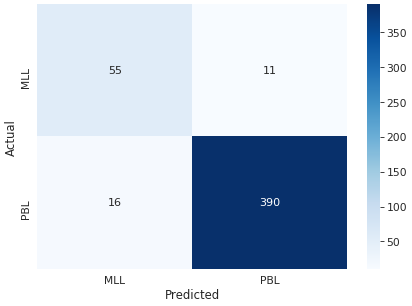

In [111]:
data = np.array([[ 55.,  11.],
                 [ 16., 390.]])
if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL'], index = ['MLL', 'PBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size

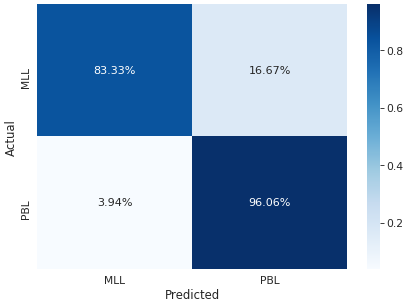

In [112]:
data = np.array([[ 55.,  11.],
                 [ 16., 390.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL'], index = ['MLL', 'PBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size

# ClassSet3

In [113]:
layers = [1,2,3,4,5]
sets = [3]

folds_n = 5
classes_n = 4

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1}
#         classes_map_dict={0:1, 1:0, 2:0, 3:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0}
#         classes_map_dict={0:1, 1:0, 2:0, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])        
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-3
Validation:
TPR=[0.68241758 0.8422162  0.63681633 0.61378151], TNR=[0.96855724 0.7913035  0.91757267 0.91529372], PPV=[0.64912281 0.77474412 0.75159537 0.64077381], NPV=[0.9744955  0.85898426 0.86825485 0.90896124], FPR=[0.03144276 0.2086965  0.08242733 0.08470628], FNR=[0.31758242 0.1577838  0.36318367 0.38621849], FDR=[0.35087719 0.22525588 0.24840463 0.35922619], ACC=[0.9473143  0.81476226 0.83950767 0.85748583], F1_micro=0.7295350275274929, F1_macro=0.69356182998239, F1_weighted=0.7267921332727943
[[ 45.  12.   0.   9.]
 [ 12. 342.  28.  24.]
 [  4.  58. 158.  28.]
 [ 10.  31.  25. 105.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.63      0.68      0.66        66
       Pigmented_benign       0.77      0.84      0.81       406
        Keratin_lesions       0.75      0.64      0.69       248
Nonmelanoma_skin_cancer       0.63      0.61      0.62       171

               accuracy                           0.73   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


              precision    recall  f1-score   support

  MLL+NonMSC       0.71      0.71      0.71       237
       PB+KL       0.90      0.90      0.90       654

    accuracy                           0.85       891
   macro avg       0.80      0.80      0.80       891
weighted avg       0.85      0.85      0.85       891

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[0.9128447  0.97536372 0.87700117 0.91810863], TNR=[0.99636317 0.94016836 0.9801745  0.97847096], PPV=[0.95344032 0.93218143 0.94542419 0.91034638], NPV=[0.99306397 0.97869979 0.95406697 0.98059699], FPR=[0.00363683 0.05983164 0.0198255  0.02152904], FNR=[0.0871553  0.02463628 0.12299883 0.08189137], FDR=[0.04655968 0.06781857 0.05457581 0.08965362], ACC=[0.99017797 0.9562171  0.95144811 0.96689009], F1_micro=0.9323666370637399, F1_macro=0.9270286851181598, F1_weighted=0.931787180472204
[[2.410e+02 1.900e+01 1.000e+00 3.000e+00]
 [4.000e+00 1.584e+03 2.1

TPR=[0.76413374 0.91606274], TNR=[0.91606274 0.76413374], PPV=[0.77571849 0.9145819 ], NPV=[0.9145819  0.77571849], FPR=[0.08393726 0.23586626], FNR=[0.23586626 0.08393726], FDR=[0.22428151 0.0854181 ], ACC=[0.87558369 0.87558369], F1_micro=0.8755836877040712, F1_macro=0.8411485570185689, F1_weighted=0.8756456598303588
[[181.  56.]
 [ 55. 599.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.77      0.76      0.77       237
       PB+KL       0.91      0.92      0.92       654

    accuracy                           0.88       891
   macro avg       0.84      0.84      0.84       891
weighted avg       0.88      0.88      0.88       891

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[0.98483309 0.99507312 0.98385361 0.99270073], TNR=[0.99909137 0.99483867 0.99689093 0.99583332], PPV=[0.98888112 0.99388161 0.9919173  0.98268016], NPV=[0.99879062 0.9958774  0.9938222  0.99826568], FPR=[0.00090

TPR=[0.74395604 0.86940681 0.72563265 0.66672269], TNR=[0.97699828 0.86379322 0.88798189 0.94726851], PPV=[0.73038961 0.84272256 0.71566973 0.75573607], NPV=[0.97948609 0.88792795 0.89344496 0.92292908], FPR=[0.02300172 0.13620678 0.11201811 0.05273149], FNR=[0.25604396 0.13059319 0.27436735 0.33327731], FDR=[0.26961039 0.15727744 0.28433027 0.24426393], ACC=[0.95962413 0.86641196 0.84278436 0.89342361], F1_micro=0.7811220303755804, F1_macro=0.7528976761332835, F1_weighted=0.7799458228396353
[[ 49.  10.   2.   5.]
 [ 10. 353.  33.  10.]
 [  3.  42. 180.  23.]
 [  6.  14.  37. 114.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.72      0.74      0.73        66
       Pigmented_benign       0.84      0.87      0.86       406
        Keratin_lesions       0.71      0.73      0.72       248
Nonmelanoma_skin_cancer       0.75      0.67      0.71       171

               accuracy                           0.78       891
              macr

### 3 - layers give best TPR for MLL class

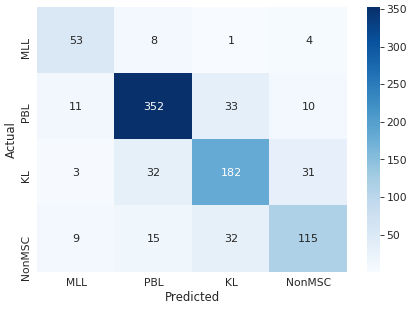

In [114]:
data = np.array([[ 53.,   8.,   1.,   4.],
                 [ 11., 352.,  33.,  10.],
                 [  3.,  32., 182.,  31.],
                 [  9.,  15.,  32., 115.]])
if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC'], index = ['MLL', 'PBL', 'KL', 'NonMSC'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size

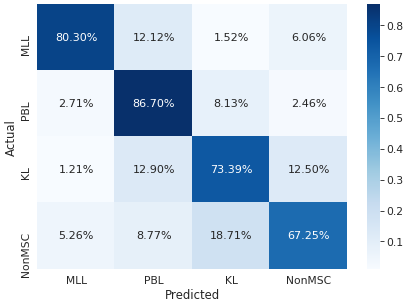

In [115]:
data = np.array([[ 53.,   8.,   1.,   4.],
                 [ 11., 352.,  33.,  10.],
                 [  3.,  32., 182.,  31.],
                 [  9.,  15.,  32., 115.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC'], index = ['MLL', 'PBL', 'KL', 'NonMSC'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size

# ClassSet4

In [116]:
layers = [1,2,3,4,5]
sets = [4]

folds_n = 5
classes_n = 2

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['C43', 'D22'])
          
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['C43', 'D22'])
              
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-4
Validation:
TPR=[0.78974359 0.97721519], TNR=[0.97721519 0.78974359], PPV=[0.85165945 0.96773359], NPV=[0.96773359 0.85165945], FPR=[0.02278481 0.21025641], FNR=[0.21025641 0.02278481], FDR=[0.14834055 0.03226641], ACC=[0.95186335 0.95186335], F1_micro=0.9518633540372671, F1_macro=0.8931593149791016, F1_weighted=0.9508759304850575
[[ 49.  13.]
 [  9. 386.]]
              precision    recall  f1-score   support

         C43       0.84      0.79      0.82        62
         D22       0.97      0.98      0.97       395

    accuracy                           0.95       457
   macro avg       0.91      0.88      0.89       457
weighted avg       0.95      0.95      0.95       457

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[0.996 1.   ], TNR=[1.    0.996], PPV=[1.         0.99936909], NPV=[0.99936909 1.        ], FPR=[0.    0.004], FNR=[0.004 0.   ], FDR=[0.         0.00063091], ACC=[0.99945355 0.9994535

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[1. 1.], TNR=[1. 1.], PPV=[1. 1.], NPV=[1. 1.], FPR=[0. 0.], FNR=[0. 0.], FDR=[0. 0.], ACC=[1. 1.], F1_micro=1.0, F1_macro=1.0, F1_weighted=1.0
[[ 248.    0.]
 [   0. 1580.]]
              precision    recall  f1-score   support

         C43       1.00      1.00      1.00       248
         D22       1.00      1.00      1.00      1580

    accuracy                           1.00      1828
   macro avg       1.00      1.00      1.00      1828
weighted avg       1.00      1.00      1.00      1828

--------------------------------
--------------------------------
Layers-3, Set-4
Validation:
TPR=[0.80512821 0.96708861], TNR=[0.96708861 0.80512821], PPV=[0.79432234 0.96955372], NPV=[0.96955372 0.79432234], FPR=[0.03291139 0.19487179], FNR=[0.19487179 0.03291139], FDR=[0.20567766 0.03044628], ACC=[0.94524606 0.94524606], F1_micro=0.9452460582895366, F1_macro=0.8836303255681983, F1_weighted=0.9454875872850719
[[ 50.  12.]
 [ 13. 382.]]
              precision    recall  f1-score   suppor

### 5- layers give best TPR for MLL class

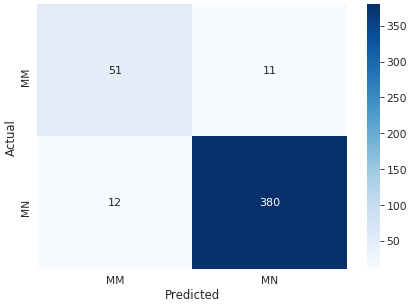

In [117]:
data = np.array([[ 51.,  11.],
                 [ 12., 380.]])
if False: 
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
# df_cm = pd.DataFrame(data, columns=['C43', 'D22'], index = ['C43', 'D22'])
df_cm = pd.DataFrame(data, columns=['MM', 'MN'], index = ['MM', 'MN'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size

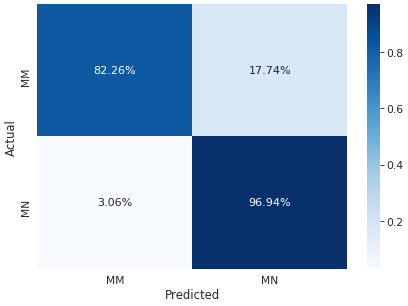

In [118]:
data = np.array([[ 51.,  11.],
                 [ 12., 380.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]

# df_cm = pd.DataFrame(data, columns=['C43', 'D22'], index = ['C43', 'D22'])
df_cm = pd.DataFrame(data, columns=['MM', 'MN'], index = ['MM', 'MN'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size

# ClassSet8

In [119]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
TPR=[0.68241758 0.71903041 0.51991837 0.41529412 0.76771501], TNR=[0.99249514 0.87800017 0.9470306  0.96668248 0.73163128], PPV=[0.84385614 0.70948219 0.69009973 0.65051527 0.62286159], NPV=[0.98447172 0.88466154 0.90177605 0.92253066 0.84600476], FPR=[0.00750486 0.12199983 0.0529694  0.03331752 0.26836872], FNR=[0.31758242 0.28096959 0.48008163 0.58470588 0.23228499], FDR=[0.15614386 0.29051781 0.30990027 0.34948473 0.37713841], ACC=[0.97781033 0.83194822 0.8713579  0.8992364  0.74472556], F1_micro=0.6625392068523464, F1_macro=0.6413666266650511, F1_weighted=0.655216606509021
[[ 45.  11.   1.   2.   7.]
 [  5. 292.  19.   6.  84.]
 [  1.  31. 129.  13.  74.]
 [  3.  11.  12.  71.  74.]
 [  1.  68.  29.  20. 390.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.82      0.68      0.74        66
       Pigmented_benign       0.71      0.72      0.71       406
        Keratin_lesions       0.68      0.52      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.85595065 0.88548718 0.74497234 0.69602834 0.91140751], TNR=[0.99605986 0.94511969 0.98848368 0.98717482 0.85691181], PPV=[0.91805498 0.86871541 0.9339933  0.88510212 0.78449137], NPV=[0.99289831 0.95291206 0.94735163 0.95898441 0.94442689], FPR=[0.00394014 0.05488031 0.01151632 0.01282518 0.14308819], FNR=[0.14404935 0.11451282 0.25502766 0.30397166 0.08859249], FDR=[0.08194502 0.13128459 0.0660067  0.11489788 0.21550863], ACC=[0.98945485 0.92780482 0.94531395 0.95157769 0.87670154], F1_micro=0.8454264260961825, F1_macro=0.8419263890277918, F1_weighted=0.8440774793185973
[[ 226.   16.    0.    6.   16.]
 [  11. 1438.   16.   13.  146.]
 [   0.   68.  739.   21.  164.]
 [   8.    6.   10.  476.  184.]
 [   2.  128.   27.   23. 1852.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.91      0.86      0.88       264
       Pigmented_benign       0.87      0.89      0.88      1624
        Keratin_lesions       0.93      0.74      0.8

TPR=[0.97780515 0.99440767], TNR=[0.99440767 0.97780515], PPV=[0.97281818 0.9954843 ], NPV=[0.9954843  0.97281818], FPR=[0.00559233 0.02219485], FNR=[0.02219485 0.00559233], FDR=[0.02718182 0.0045157 ], ACC=[0.99159962 0.99159962], F1_micro=0.9915996245567598, F1_macro=0.9850832204459025, F1_weighted=0.9916033837938502
[[ 927.   21.]
 [  26. 4622.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.97      0.98      0.98       948
 PB+KL+Other       1.00      0.99      0.99      4648

    accuracy                           0.99      5596
   macro avg       0.98      0.99      0.99      5596
weighted avg       0.99      0.99      0.99      5596

--------------------------------
--------------------------------
Layers-3, Set-8
Validation:
TPR=[0.75824176 0.79792231 0.59673469 0.46756303 0.76767618], TNR=[0.98500996 0.88816307 0.94787378 0.96664587 0.80341902], PPV=[0.72526611 0.74514154 0.71221216 0.66563389 0.6942265 ], NPV=[0.98796385 0.9152279  0.91618817 0.9

TPR=[0.75934066 0.98199109], TNR=[0.98199109 0.75934066], PPV=[0.67248168 0.98794383], NPV=[0.98794383 0.67248168], FPR=[0.01800891 0.24065934], FNR=[0.24065934 0.01800891], FDR=[0.32751832 0.01205617], ACC=[0.97139944 0.97139944], F1_micro=0.9713994422694601, F1_macro=0.8483494675742446, F1_weighted=0.9720126446495201
[[  50.   16.]
 [  24. 1309.]]
                    precision    recall  f1-score   support

               MLL       0.68      0.76      0.71        66
PB+KL+NonMSC+Other       0.99      0.98      0.98      1333

          accuracy                           0.97      1399
         macro avg       0.83      0.87      0.85      1399
      weighted avg       0.97      0.97      0.97      1399

--------------------------------
Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:
TPR=[0.60720799 0.95354364], TNR=[0.95354364 0.60720799], PPV=[0.72726853 0.92311884], NPV=[0.92311884 0.72726853], FPR=[0.04645636 0.39279201], FNR=[0.3927

TPR=[0.9831131  0.99655983], TNR=[0.99655983 0.9831131 ], PPV=[0.98330249 0.99656646], NPV=[0.99656646 0.98330249], FPR=[0.00344017 0.0168869 ], FNR=[0.0168869  0.00344017], FDR=[0.01669751 0.00343354], ACC=[0.99428427 0.99428427], F1_micro=0.9942842663590051, F1_macro=0.9898406647802472, F1_weighted=0.9942846080648738
[[ 932.   16.]
 [  16. 4632.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.98      0.98      0.98       948
 PB+KL+Other       1.00      1.00      1.00      4648

    accuracy                           0.99      5596
   macro avg       0.99      0.99      0.99      5596
weighted avg       0.99      0.99      0.99      5596

--------------------------------
--------------------------------


### 2 - layers have best TPR for clas MLL

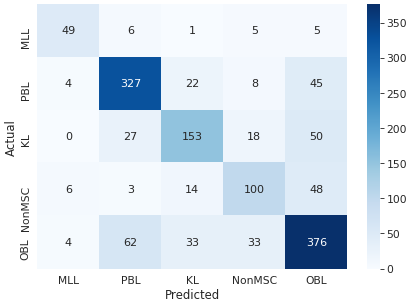

In [121]:
data = np.array([[ 49.,   6.,   1.,   5.,   5.],
                 [  4., 327.,  22.,   8.,  45.],
                 [  0.,  27., 153.,  18.,  50.],
                 [  6.,   3.,  14., 100.,  48.],
                 [  4.,  62.,  33.,  33., 376.]])
if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

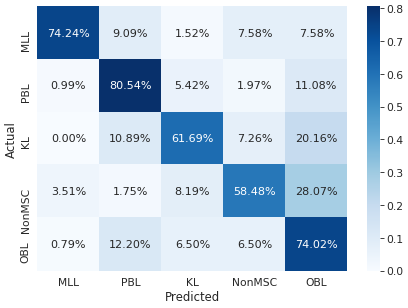

In [122]:
data = np.array([[ 49.,   6.,   1.,   5.,   5.],
                 [  4., 327.,  22.,   8.,  45.],
                 [  0.,  27., 153.,  18.,  50.],
                 [  6.,   3.,  14., 100.,  48.],
                 [  4.,  62.,  33.,  33., 376.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

## ClassSet8 - NonMSC vs rest

In [124]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
#         multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
    
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
        
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.96668248 0.41529412], TNR=[0.41529412 0.96668248], PPV=[0.92253066 0.65051527], NPV=[0.65051527 0.92253066], FPR=[0.58470588 0.03331752], FNR=[0.03331752 0.58470588], FDR=[0.07746934 0.34948473], ACC=[0.8992364 0.8992364], F1_micro=0.8992364018551624, F1_macro=0.7191605511195915, F1_weighted=0.8889482451410806
[[1187.   41.]
 [ 100.   71.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.92      0.97      0.94      1228
         NonMSC       0.63      0.42      0.50       171

       accuracy                           0.90      1399
      macro avg       0.78      0.69      0.72      1399
   weighted avg       0.89      0.90      0.89      1399

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.98717482 0.69602834], TNR=[0.69602834 0.9

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.94790966 0.58504202], TNR=[0.58504202 0.94790966], PPV=[0.94258253 0.60817227], NPV=[0.60817227 0.94258253], FPR=[0.41495798 0.05209034], FNR=[0.05209034 0.41495798], FDR=[0.05741747 0.39182773], ACC=[0.90352213 0.90352213], F1_micro=0.9035221341688345, F1_macro=0.7703781131565044, F1_weighted=0.902442804249284
[[1164.   64.]
 [  71.  100.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.94      0.95      0.95      1228
         NonMSC       0.61      0.58      0.60       171

       accuracy                           0.90      1399
      macro avg       0.78      0.77      0.77      1399
   weighted avg       0.90      0.90      0.90      1399

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.99430128 0.97219837], TNR=[0.97219837 0.99430128], PPV=[0.99612722 0

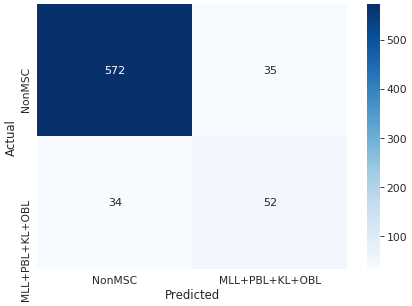

In [54]:
data = np.array([[572.,  35.],
                 [ 34.,  52.]])
if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

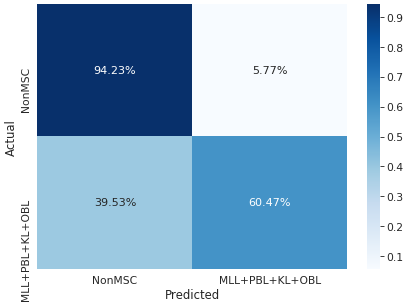

In [56]:
data = np.array([[572.,  35.],
                 [ 34.,  52.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

# Playground

In [191]:


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [202]:
# plot_confusion_matrix(cm           = np.array([[ 32.,   7.,   1.,   5.,   2.],
#                                              [  5., 327.,  25.,   8.,  42.],
#                                              [  1.,  32., 161.,  13.,  41.],
#                                              [  7.,   4.,  17., 100.,  43.],
#                                              [  7.,  63.,  28.,  35., 375.]]), 
#                       normalize    = False,
#                       target_names = ['MLL', 'PBL', 'KL', 'NonMSC', 'Other'],
#                       title        = "Confusion Matrix")

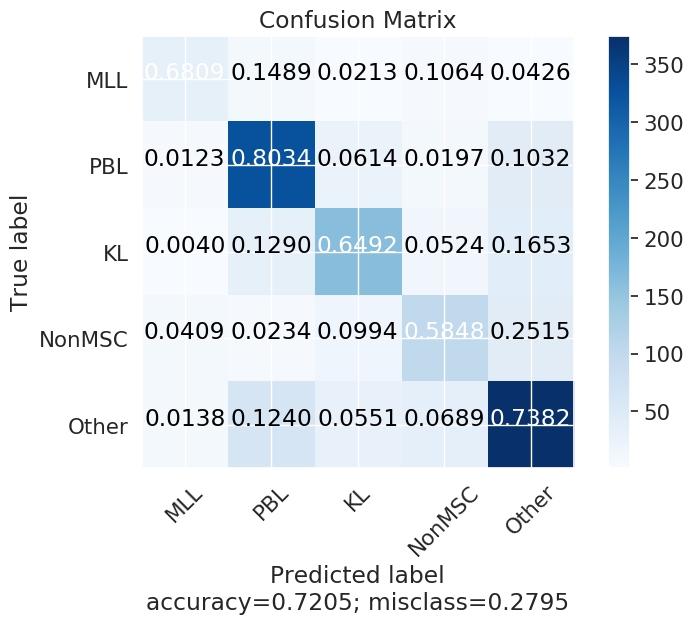

In [193]:
# fig = plt.figure(figsize=(6, 6), dpi=300)
plot_confusion_matrix(cm           = np.array([[ 32.,   7.,   1.,   5.,   2.],
                                             [  5., 327.,  25.,   8.,  42.],
                                             [  1.,  32., 161.,  13.,  41.],
                                             [  7.,   4.,  17., 100.,  43.],
                                             [  7.,  63.,  28.,  35., 375.]]), 
                      normalize    = True,
                      target_names = ['MLL', 'PBL', 'KL', 'NonMSC', 'Other'],
                      title        = "Confusion Matrix")